<a href="https://colab.research.google.com/github/praymesh/VLM-SEGMENTATION/blob/main/Visual_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torch.nn as nn
import torch.functional as F
from transformers import AutoProcessor, AutoModel
from PIL import Image
import numpy as np


Comparision of Sg1 and Sg2 : https://huggingface.co/spaces/google/zero-shot-sg1-sg2\

SigLIP 2 is pre-trained on the WebLI dataset (Chen et al., 2023).
Model Used as of Now : google/siglip2-base-patch16-224-jax : https://huggingface.co/google/siglip2-base-patch16-224-jax

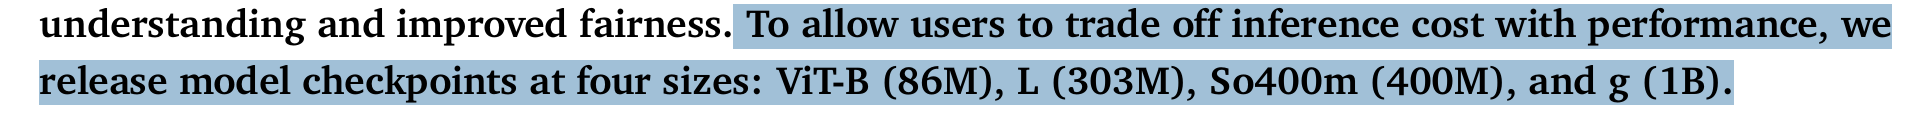

In [ ]:
# ! pip install ipywidgets #vs code

   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   --------- ------------------------------ 0.5/2.2 MB 5.6 MB/s eta 0:00:01
   ------------------- -------------------- 1.0/2.2 MB 2.4 MB/s eta 0:00:01
   ----------------------- ---------------- 1.3/2.2 MB 2.3 MB/s eta 0:00:01
   --------------------------------- ------ 1.8/2.2 MB 2.0 MB/s eta 0:00:01
   --------------------------------- ------ 1.8/2.2 MB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 1.6 MB/s eta 0:00:00


In [ ]:
# huggngface auth

from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# replacing CLIP with SIGLIP 2, We Will use the Base Model
model_name = "google/siglip2-base-patch16-224-jax"
processor = AutoProcessor.from_pretrained(model_name)
siglip2 = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

KeyboardInterrupt: 

# INPUT IMAGE PROCESSING/Loading DATASET :


In [1]:
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T


In [2]:
# from https://github.com/nightrome/cocostuff/blob/master/README.md#setup
# Get this repo
!git clone https://github.com/nightrome/cocostuff.git
!cd cocostuff

# Download everything
!wget --directory-prefix=downloads http://images.cocodataset.org/zips/train2017.zip
!wget --directory-prefix=downloads http://images.cocodataset.org/zips/val2017.zip
!wget --directory-prefix=downloads http://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/stuffthingmaps_trainval2017.zip

# Unpack everything
!mkdir -p dataset/images
!mkdir -p dataset/annotations
!unzip downloads/train2017.zip -d dataset/images/
!unzip downloads/val2017.zip -d dataset/images/
!unzip downloads/stuffthingmaps_trainval2017.zip -d dataset/annotations/

Streaming output truncated to the last 5000 lines.
  inflating: dataset/annotations/val2017/000000222235.png  
  inflating: dataset/annotations/val2017/000000038678.png  
  inflating: dataset/annotations/val2017/000000189698.png  
  inflating: dataset/annotations/val2017/000000208363.png  
 extracting: dataset/annotations/val2017/000000572956.png  
  inflating: dataset/annotations/val2017/000000384513.png  
 extracting: dataset/annotations/val2017/000000471893.png  
 extracting: dataset/annotations/val2017/000000302536.png  
  inflating: dataset/annotations/val2017/000000531036.png  
  inflating: dataset/annotations/val2017/000000087038.png  
  inflating: dataset/annotations/val2017/000000488736.png  
  inflating: dataset/annotations/val2017/000000012120.png  
  inflating: dataset/annotations/val2017/000000341196.png  
  inflating: dataset/annotations/val2017/000000470779.png  
  inflating: dataset/annotations/val2017/000000397303.png  
 extracting: dataset/annotations/val2017/00000039

In [3]:
# prompt: check the size and stucture of dataset

# Check the size of the dataset directories
!du -sh dataset/images/train2017
!du -sh dataset/images/val2017
!du -sh dataset/annotations/stuffthingmaps_trainval2017

# Count the number of files in each directory (basic structure check)
!ls dataset/images/train2017 | wc -l
!ls dataset/images/val2017 | wc -l
!ls dataset/annotations/stuffthingmaps_trainval2017 | wc -l

# List a few files from each directory to see the naming convention (basic structure check)
!ls dataset/images/train2017 | head -n 5
!ls dataset/images/val2017 | head -n 5
!ls dataset/annotations/stuffthingmaps_trainval2017 | head -n 5


19G	dataset/images/train2017
788M	dataset/images/val2017
du: cannot access 'dataset/annotations/stuffthingmaps_trainval2017': No such file or directory
118287
5000
ls: cannot access 'dataset/annotations/stuffthingmaps_trainval2017': No such file or directory
0
000000000009.jpg
000000000025.jpg
000000000030.jpg
000000000034.jpg
000000000036.jpg
000000000139.jpg
000000000285.jpg
000000000632.jpg
000000000724.jpg
000000000776.jpg
ls: cannot access 'dataset/annotations/stuffthingmaps_trainval2017': No such file or directory


In [4]:
# prompt: Help me save the dataset in my drive so that i dont  need to aceess everytime ,

from google.colab import drive
drive.mount('/content/drive')

# Create target directories in Google Drive
!mkdir -p /content/drive/MyDrive/coco_dataset/images
!mkdir -p /content/drive/MyDrive/coco_dataset/annotations

# Move the downloaded and unpacked dataset files to Google Drive
!mv dataset/images/* /content/drive/MyDrive/coco_dataset/images/
!mv dataset/annotations/* /content/drive/MyDrive/coco_dataset/annotations/

print("Dataset saved to Google Drive at /content/drive/MyDrive/coco_dataset/")


Mounted at /content/drive
^C
^C
Dataset saved to Google Drive at /content/drive/MyDrive/coco_dataset/


In [23]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
import random # Import random to use random.choice

# Define the base dataset path
dataset_path = 'dataset/'
image_dir_train = os.path.join(dataset_path, 'images', 'train2017')
annotation_dir_train = os.path.join(dataset_path, 'annotations', 'stuffthingmaps_trainval2017', 'train2017') # Corrected annotation path based on ls output

# Choose a random image file from the training set
image_files = [f for f in os.listdir(image_dir_train) if f.endswith('.jpg')]

if not image_files:
    print("No image files found in the training directory.")
else:
    random_image_file = random.choice(image_files)
    img_path = os.path.join(image_dir_train, random_image_file)

    # Construct the corresponding mask path
    image_id = os.path.splitext(random_image_file)[0] # Get the image ID without extension
    mask_file = f"{image_id}.png" # Annotation files are PNG
    mask_path = os.path.join(annotation_dir_train, mask_file)


    # Load image and mask
    try:
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask_np = np.array(mask)

        print(f"Successfully loaded image: {img_path}")
        print(f"Successfully loaded mask: {mask_path}")

        # Load COCO-Stuff class names
        # You might need to update this path if cocostuff_labels.json is not in the default directory
        # For now, assuming it's in the same directory as the notebook or accessible.
        # If you don't have this file, you'll need to download it or create it based on the dataset.
        try:
            with open("cocostuff_labels.json", "r") as f:
                label_info = json.load(f)
            class_names = [entry['name'] for entry in label_info]
            class_colors = {entry['id']: entry['color'] for entry in label_info}
        except FileNotFoundError:
            print("Error: cocostuff_labels.json not found. Please make sure the file is in the correct path.")
            class_names = None
            class_colors = None

        # You can add visualization code here if you want to display the image and mask after loading
        # For example:
        # plt.figure(figsize=(10, 5))
        # plt.subplot(1, 2, 1)
        # plt.imshow(image)
        # plt.title("Image")
        # plt.axis('off')
        # plt.subplot(1, 2, 2)
        # plt.imshow(mask_np, cmap='viridis') # Using a colormap for the mask
        # plt.title("Mask")
        # plt.axis('off')
        # plt.show()

    except FileNotFoundError as e:
        print(f"Error loading file: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

Error loading file: [Errno 2] No such file or directory: 'dataset/annotations/stuffthingmaps_trainval2017/train2017/000000026241.png'


NameError: name 'class_colors' is not defined

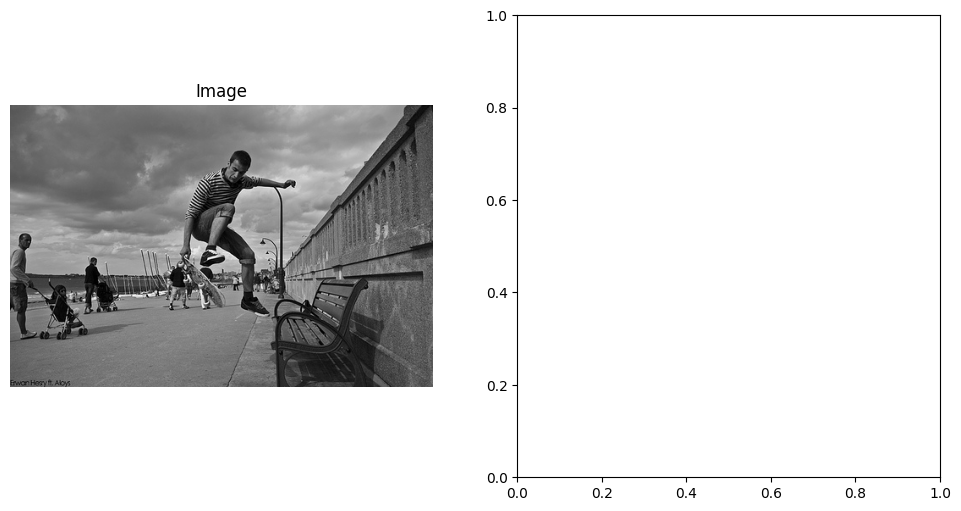

In [32]:
# prompt: his is coco dataset, segmenation so help me visualise the mask as well as image  , any random image and its mask  , images are in dataset/images/train2017 and annotations , mask images(png
# ) in dataset/ annotation

# You can add visualization code here if you want to display the image and mask after loading
# For example:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
# Create a color mask if class_colors are available
if class_colors:
    colored_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)
    for class_id, color in class_colors.items():
        colored_mask[mask_np == class_id] = color
    plt.imshow(colored_mask)
    plt.title("Colored Mask")
else:
    plt.imshow(mask_np, cmap='viridis') # Using a colormap for the mask
    plt.title("Grayscale Mask")

plt.axis('off')
plt.tight_layout()
plt.show()

# Optional: Print some info about the mask values
unique_mask_values = np.unique(mask_np)
print(f"Unique mask values (class IDs): {unique_mask_values}")

if class_names:
    print("Corresponding class names:")
    for value in unique_mask_values:
        if value < len(class_names):
            print(f"ID {value}: {class_names[value]}")
        else:
            print(f"ID {value}: Unknown Class")


In [17]:
# prompt:
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define the paths to your dataset in Google Drive
dataset_path = 'dataset/'
image_dir = os.path.join(dataset_path, 'images')
annotation_dir = os.path.join(dataset_path, 'annotations', 'stuffthingmaps_trainval2017')

# Choose a random image and its corresponding annotation mask
def get_random_image_and_mask(image_folder, annotation_folder):
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
    if not image_files:
        return None, None, None

    random_image_file = random.choice(image_files)
    image_id = os.path.splitext(random_image_file)[0] # Get the image ID without extension
    annotation_file = f"{image_id}.png" # Annotation files are PNG
    annotation_path = os.path.join(annotation_folder, annotation_file)

    image_path = os.path.join(image_folder, random_image_file)

    if os.path.exists(annotation_path):
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(annotation_path)
        return image, mask, random_image_file
    else:
        print(f"Annotation not found for image: {random_image_file}")
        return None, None, None

# Helper function to display the image and mask
def visualize_image_and_mask(image, mask, title="Image and Mask"):
    if image is None or mask is None:
        print("No image or mask to display.")
        return

    mask_np = np.array(mask)

    # COCO Stuff and Thing dataset encodes both stuff (semantic) and thing (instance) masks
    # in the same image. Pixel values < 91 are stuff classes, >= 91 are thing instances.
    # For visualization, we can just use the raw pixel values which correspond to class IDs (or instance IDs).
    # To make the mask visible on the image, we can overlay it with some transparency.

    # Create a colormap (you might want a better one for actual analysis)
    # For simplicity, let's just create a random colormap or use a standard one.
    # A simple approach is to normalize the mask values for a grayscale representation,
    # or assign a color to each unique class ID.
    unique_labels = np.unique(mask_np)
    print(f"Unique labels in the mask: {unique_labels}")

    # Create a color image from the mask
    mask_color = Image.fromarray(mask_np.astype(np.uint8), mode='P') # Use 'P' mode for colormap
    mask_color.putpalette(np.random.randint(0, 256, size=768).tolist()) # Assign a random colormap

    # Ensure mask_color is RGB to blend with the image
    mask_color = mask_color.convert("RGB")

    # Blend the image and the mask
    blended_image = Image.blend(image.convert("RGBA"), mask_color.convert("RGBA"), alpha=0.5)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask_np, cmap='viridis') # Display the mask as grayscale or with a colormap
    plt.title("Segmentation Mask (Pixel Values)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(blended_image)
    plt.title("Image with Mask Overlay")
    plt.axis('off')

    plt.suptitle(title)
    plt.show()

# Get a random image and mask from the training set (you can choose validation as well)
random_image, random_mask, image_filename = get_random_image_and_mask(os.path.join(image_dir, 'train2017'), os.path.join(annotation_dir, 'train2017'))

# Visualize the random image and its mask
if random_image and random_mask:
    visualize_image_and_mask(random_image, random_mask, title=f"Random Image and Mask: {image_filename}")


Annotation not found for image: 000000209289.jpg


In [16]:
# Method 2 : Download the dataset via shell (Colab) #from COC stu
!mkdir -p coco2017/images
!wget http://images.cocodataset.org/zips/train2017.zip
!unzip -q train2017.zip -d coco2017/images

!mkdir -p coco2017/annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q annotations_trainval2017.zip -d coco2017/annotations


--2025-06-20 10:51:53--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.87.132, 3.5.16.156, 16.15.194.30, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.87.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip.3’

train2017.zip.3       0%[                    ] 183.54M  50.9MB/s    eta 6m 8s  ^C
[train2017.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of train2017.zip or
        train2017.zip.zip, and cannot find train2017.zip.ZIP, period.
--2025-06-20 10:51:57--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.coco

In [1]:
from torchvision.datasets import CocoDetection
dataset = CocoDetection(
    root='/content/coco2017/images/train2017',
    annFile='/content/coco2017/annotations/instances_train2017.json',
    transform=T.ToTensor()
)

SyntaxError: incomplete input (ipython-input-1-3420494280.py, line 5)

In [22]:
# List the contents of the dataset directory to inspect the structure
!ls -R dataset/

Streaming output truncated to the last 5000 lines.
000000126815.jpg  000000273337.jpg  000000417547.jpg  000000563726.jpg
000000126816.jpg  000000273352.jpg  000000417549.jpg  000000563727.jpg
000000126817.jpg  000000273354.jpg  000000417556.jpg  000000563730.jpg
000000126822.jpg  000000273358.jpg  000000417570.jpg  000000563731.jpg
000000126825.jpg  000000273362.jpg  000000417571.jpg  000000563734.jpg
000000126826.jpg  000000273363.jpg  000000417573.jpg  000000563739.jpg
000000126832.jpg  000000273369.jpg  000000417577.jpg  000000563743.jpg
000000126833.jpg  000000273371.jpg  000000417583.jpg  000000563746.jpg
000000126856.jpg  000000273378.jpg  000000417586.jpg  000000563762.jpg
000000126869.jpg  000000273379.jpg  000000417588.jpg  000000563763.jpg
000000126870.jpg  000000273383.jpg  000000417590.jpg  000000563764.jpg
000000126876.jpg  000000273387.jpg  000000417594.jpg  000000563767.jpg
000000126877.jpg  000000273403.jpg  000000417595.jpg  000000563771.jpg
000000126894.jpg  00000027

In [25]:
# Download cocostuff_labels.json if it's not present
import requests
import os

label_file_url = "https://raw.githubusercontent.com/nightrome/cocostuff/master/mat/cocostuff_labels.json"
label_file_name = "cocostuff_labels.json"

if not os.path.exists(label_file_name):
    print(f"Downloading {label_file_name}...")
    try:
        response = requests.get(label_file_url)
        response.raise_for_status()  # Raise an exception for bad status codes
        with open(label_file_name, "wb") as f:
            f.write(response.content)
        print(f"{label_file_name} downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {label_file_name}: {e}")
else:
    print(f"{label_file_name} already exists.")

Error downloading cocostuff_labels.json: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/nightrome/cocostuff/master/mat/cocostuff_labels.json


In [26]:
# List the contents of the extracted annotation directory
!ls -R dataset/annotations/stuffthingmaps_trainval2017/

ls: cannot access 'dataset/annotations/stuffthingmaps_trainval2017/': No such file or directory


In [27]:
# List the contents of the dataset/annotations directory
!ls -R dataset/annotations/

Streaming output truncated to the last 5000 lines.
000000126815.png  000000273337.png  000000417547.png  000000563726.png
000000126816.png  000000273352.png  000000417549.png  000000563727.png
000000126817.png  000000273354.png  000000417556.png  000000563730.png
000000126822.png  000000273358.png  000000417570.png  000000563731.png
000000126825.png  000000273362.png  000000417571.png  000000563734.png
000000126826.png  000000273363.png  000000417573.png  000000563739.png
000000126832.png  000000273369.png  000000417577.png  000000563743.png
000000126833.png  000000273371.png  000000417583.png  000000563746.png
000000126856.png  000000273378.png  000000417586.png  000000563762.png
000000126869.png  000000273379.png  000000417588.png  000000563763.png
000000126870.png  000000273383.png  000000417590.png  000000563764.png
000000126876.png  000000273387.png  000000417594.png  000000563767.png
000000126877.png  000000273403.png  000000417595.png  000000563771.png
000000126894.png  00000027